In [ ]:
# import libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [296]:
%run make_model.ipynb

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 371ms/step - accuracy: 0.0568 - loss: 3.8534 - val_accuracy: 0.1333 - val_loss: 2.4335
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 393ms/step - accuracy: 0.1377 - loss: 2.4101 - val_accuracy: 0.2467 - val_loss: 2.0896
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.2706 - loss: 1.9860 - val_accuracy: 0.6500 - val_loss: 1.0071
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.5369 - loss: 1.3013 - val_accuracy: 0.8367 - val_loss: 0.6609
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 365ms/step - accuracy: 0.6025 - loss: 0.9988 - val_accuracy: 0.7933 - val_loss: 0.4840
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 362ms/step - accuracy: 0.6570 - loss: 0.8680 - val_accuracy: 0.8733 - val_loss: 0.3196
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 363ms/step - accuracy: 0.7230 - loss: 0.7175 - val_accuracy: 0.9067 - val_loss: 0.2762
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 376ms/step - accuracy: 0.7775 - loss: 0.6455 - val_accuracy: 0.913

[ WARN:0@20912.911] global loadsave.cpp:268 findDecoder imread_('images/training_notes/5_16.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


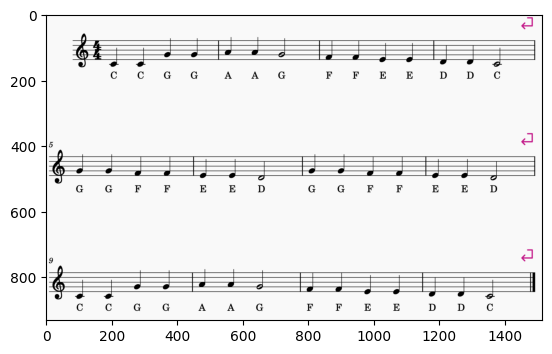

In [408]:
# read image
twinkle = np.array(Image.open("images/sheet_music/twinkle_treble.png"))
plt.imshow(twinkle)
plt.show()
# TODO: Error checking

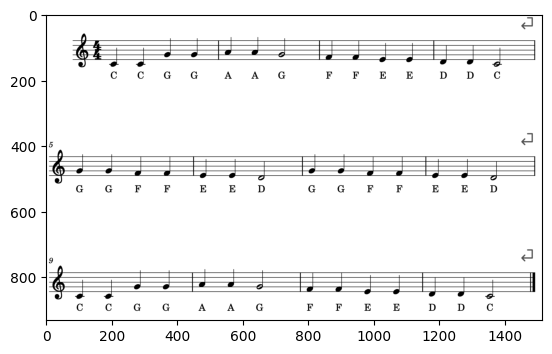

In [409]:
# convert to grayscale 
gray = cv2.cvtColor(twinkle, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()


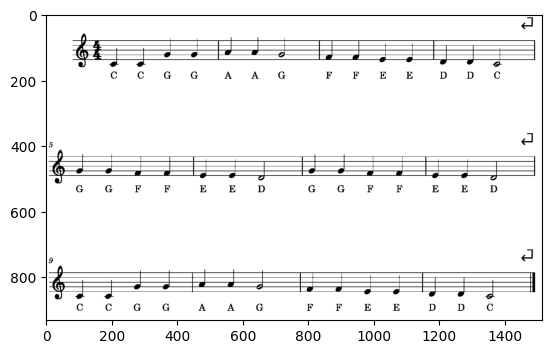

In [410]:
# convert to binary
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')
plt.show()

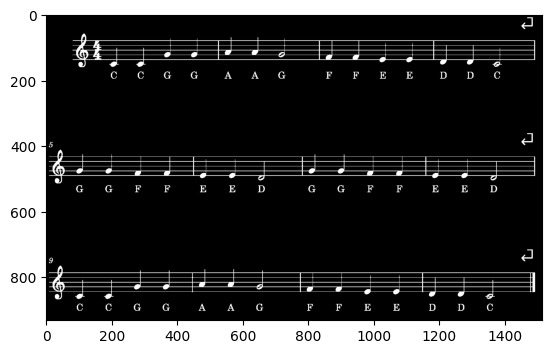

In [411]:
# invert the image: background = black, foreground = white
invert = cv2.bitwise_not(binary)
plt.imshow(invert, cmap='gray')
plt.show()

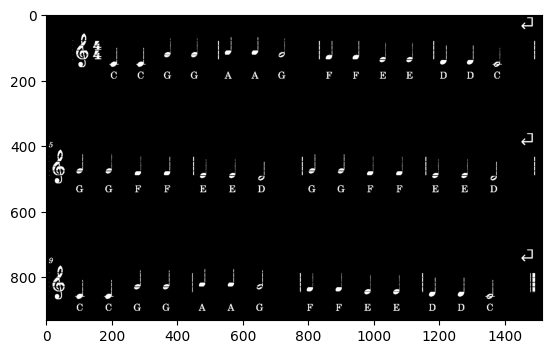

In [412]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
staff_lines = cv2.morphologyEx(invert, cv2.MORPH_OPEN, kernel)
no_staff=cv2.subtract(invert, staff_lines)
plt.imshow(no_staff, cmap='gray')
plt.show()

In [413]:
test_img = cv2.imread("images/training_notes/C4_1.png")
h, w, _ = test_img.shape
print(test_img.shape)

(438, 136, 3)


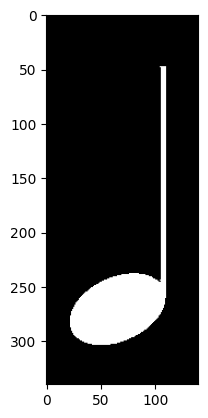

In [432]:
template = cv2.imread('images/quarter_note_template2.png', 0)
# template = cv2.resize(template, (50, 150))
_, template = cv2.threshold(template, 127, 255, cv2.THRESH_BINARY)
template = cv2.bitwise_not(template)
plt.imshow(template, cmap='gray')
plt.show()

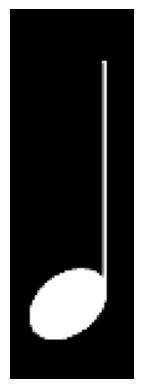

In [511]:
template = cv2.resize(template, (50, 150))
plt.imshow(template, cmap='gray')
plt.axis('off')
plt.show()

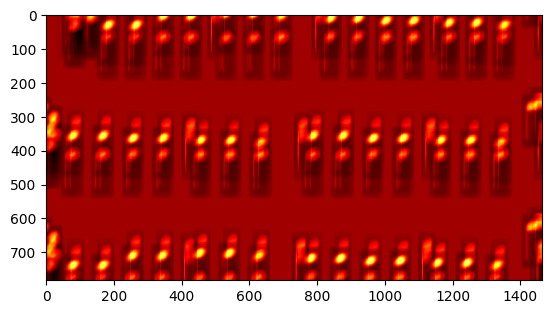

In [521]:
# match template
result = cv2.matchTemplate(no_staff, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.55 # adjust for sensitivity
locations = np.where(result >= threshold)
plt.imshow(result, cmap='hot')
plt.show()

In [537]:
w, h = template.shape[::-1]
print(w, h)
candidates = []
for pt in zip(*locations[::-1]):
    x, y = pt
    crop = gray[y:y+h, x:x+w]
    candidates.append((x, y, crop))

50 150


In [538]:
print(len(candidates))
# print(candidates[0].shape)

26


(438, 136, 3)


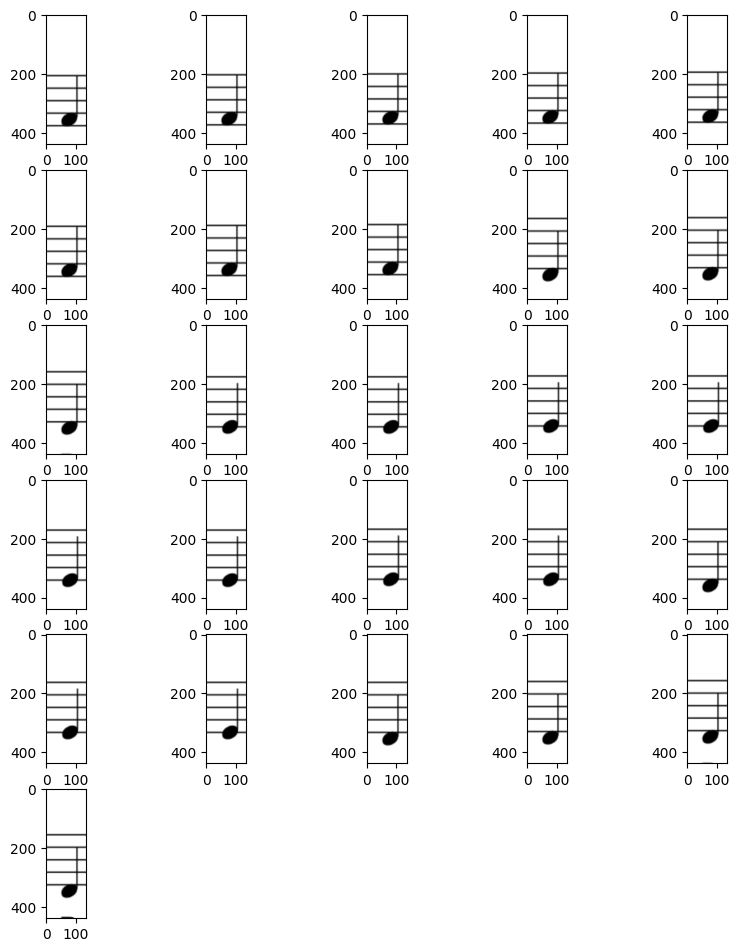

In [540]:
processed_X = []
positions = []

test_img = cv2.imread("images/training_notes/C4_1.png")
h, w, _ = test_img.shape
print(test_img.shape)

# plot
n = len(candidates)
cols = 5
rows = (n+cols-1)
i = 0

plt.figure(figsize=(cols*2, rows*2))

for x, y, crop in candidates:
    # resized=crop
    resized = cv2.resize(crop, (w, h))
    normalized = resized / 255.0
    reshaped = normalized.reshape(1, h, w, 1)  # add batch and channel dimensions

    processed_X.append(reshaped)
    positions.append((x, y))  # save position for post-prediction display or MIDI mapping
    
    plt.subplot(rows, cols, i+1)
    plt.imshow(reshaped.reshape(h, w), cmap='gray')
    plt.axis('on')
    i = i + 1


In [ ]:
processed_X = np.vstack(processed_X)  # combine into (N, 28, 28, 1)
preds = model.predict(processed_X)
pred_labels = np.argmax(preds, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


In [526]:
print(pred_labels)

[2 1 1 1 2 2 2 2 2 1 1 1 1 1 1 3 3 3 3 2 3 3 2 1 1 1]


In [527]:
# Map class indices to note names
label_map = {
    'C4': 0, 'D4': 1, 'E4': 2, 'F4': 3, 'G4': 4, 'A4': 5, 'B4': 6, 'C5': 7, 
    'D5': 8, 'E5': 9, 'F5': 10, 'G5': 11, 'A5': 12, 'B5': 13,'C6': 14
}

In [528]:
pitches = []
for pred in pred_labels:
    pitch = list(label_map.keys())[pred]
    pitches.append(pitch)
print(pitches)

['E4', 'D4', 'D4', 'D4', 'E4', 'E4', 'E4', 'E4', 'E4', 'D4', 'D4', 'D4', 'D4', 'D4', 'D4', 'F4', 'F4', 'F4', 'F4', 'E4', 'F4', 'F4', 'E4', 'D4', 'D4', 'D4']


In [166]:
treble_note_to_midi = {
    'C4': 60,
    'D4': 62, 
    'E4': 64, 
    'F4': 65,
    'G4': 67,
    'A4': 69,
    'B4': 71,
    'C5': 72,
    'D5': 74,
    'E5': 76,
    'F5': 77,
    'G5': 79,
    'A5': 81,
    'B5': 83,
    'C6': 84,
}

In [25]:
def extract_features(image_patch):
    resized = cv2.resize(image_patch, (20, 20)).flatten()
    return resized / 255.0 # normalize 